In [1]:
%load_ext autoreload
%autoreload 2
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp
from flax.training import train_state, checkpoints

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import GNNBenchmarkDataset, TUDataset

from src import get_nparams, get_graph, to_device_split, init_model, train_loop, eval_nfold, eval_loop

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


/skunk-pod-storage-phamb-40rpi-2eedu-pvc/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-15 19:48:28.744134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from typing import Callable
from functools import partial
import jax.experimental.sparse as jsparse
from optax._src.loss import smooth_labels, softmax_cross_entropy

smooth_labels = jax.vmap(partial(smooth_labels, alpha=0.05))
softmax_cross_entropy = jax.vmap(partial(softmax_cross_entropy))

@jax.vmap
def Accuracy(preds: jnp.ndarray, targets: jnp.ndarray):
    chex.assert_equal_shape((preds, targets))
    return (preds == targets).mean()


def compute_loss(
    params,
    data: dict,
    apply_fn: Callable,
    kclasses: int,
    to_device: bool,
    **kwargs
):
    
    labels = data.pop('Y')
    
    # CLS, X, A, stats
    results = apply_fn({'params': params}, data['X'], data['A'], data['P'], data['key'], False, True)
    
    logits = results['CLS']
    
    loss = softmax_cross_entropy(
        logits, smooth_labels(jax.nn.one_hot(labels, kclasses))
    ).mean()
    
    accuracy = Accuracy(jnp.argmax(logits, axis=-1).squeeze(), labels).mean()
        
    if to_device:
        loss, accuracy = map(lambda x : jax.lax.pmean(x, 'batch'), (loss, accuracy))
        
    return loss, accuracy

In [3]:
model_name = data_name = 'DD'      # change name
saved_dir = "./saved_models/" + model_name
path = './stats/' + model_name + '_stats.npy'

batch_size = 64 # 32 * 2
valid_loader = None
train_data = TUDataset(root = '../data/', name = data_name, use_node_attr=True)

In [4]:
from src import GraphET

k = 15                       # N x k pos_embedding dim we want to use (2 * k if we use svd)
kclasses = 10                # output dim
embed_type = 'eigen'         # pos_embedding type
task_level = 'graph'         # graph or node level 
to_device = True
max_num_nodes = 500

model = GraphET(
    embed_dim = 128,
    out_dim = kclasses, 
    nheads = 12,
    alpha = 0.1,
    depth = 1,
    block = 4,
    head_dim = 64,
    multiplier = 4.,
    dtype = jnp.float32,
    kernel_size = [3, 3],
    kernel_dilation = [1, 1],
    compute_corr = True,
    vary_noise = False,
    chn_atype = 'relu',
)

key = jax.random.PRNGKey(42)

params = init_model(
    DataLoader(train_data, batch_size = 1), key, model, k, embed_type, task_level)

print("PARAMS COUNT:", get_nparams(params))

PARAMS COUNT: 1064834


In [5]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
key, _ = jax.random.split(key)
g.manual_seed(3407 + int(jnp.mean(key)))

train_loader = DataLoader(train_data, shuffle = True, batch_size = batch_size, worker_init_fn = seed_worker, generator = g)

In [6]:
epochs = 300

warmup_steps = 50 * len(train_loader) 
total_steps = len(train_loader) * epochs

scheduler = optax.warmup_cosine_decay_schedule(
    init_value = 5e-6,
    peak_value = 1e-3,
    warmup_steps = warmup_steps,
    decay_steps = total_steps,
    end_value = 5e-6,
)

optimizer = optax.chain(
    optax.centralize(),
    optax.adamw(
        learning_rate = scheduler, 
        weight_decay=0.05,
        b1=0.9,
        b2=0.99,
    ),
)    

state = train_state.TrainState.create(apply_fn = model.apply, params = params, tx = optimizer)
state = checkpoints.restore_checkpoint(ckpt_dir = saved_dir, target = state)

if to_device:
    state = flax.jax_utils.replicate(state)

In [7]:
train_compute_loss = partial(compute_loss, to_device=False, kclasses=kclasses, apply_fn=state.apply_fn)

valid_compute_loss = jax.pmap(
    partial(compute_loss, to_device=to_device, kclasses=kclasses, apply_fn=state.apply_fn),
    axis_name='batch',
    in_axes=(0, {'X': 0, 'Y': 0, 'P': 0, 'A': 0, 'key': 0})
)

get_train_data = partial(
    get_graph, 
    max_num_nodes = max_num_nodes, 
    k = k, 
    embed_type = embed_type,
    task_level = task_level,
    to_device = to_device,
    flip_sign = True
)
 
get_valid_data = partial(
    get_graph, 
    max_num_nodes = max_num_nodes, 
    k = k, 
    embed_type = embed_type,
    task_level = task_level,
    to_device = to_device,
    flip_sign = False
)

In [8]:
key, state = train_loop(
    state, 
    {'train': train_loader, 'valid': valid_loader},
    {'train': get_train_data, 'valid': get_valid_data},
    train_compute_loss,
    valid_compute_loss,
    epochs,
    path = path
)

print("Total epochs:", jnp.mean(state.step / len(train_loader)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [3:06:32<00:00, 37.31s/it, train_accuracy=0.98, train_loss=0.35, val_accuracy=0, val_loss=0]


Saved statistics to ./etc/DD_stats.npy
Total epochs: 300.0


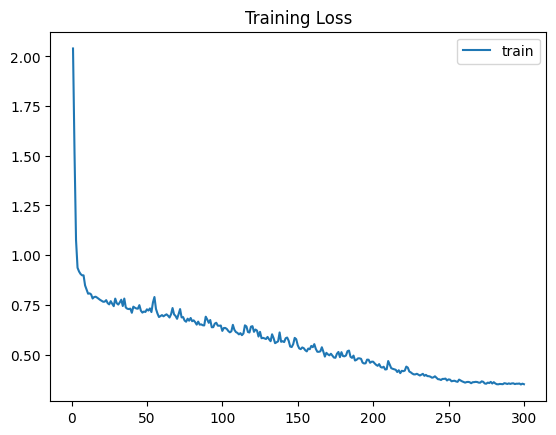

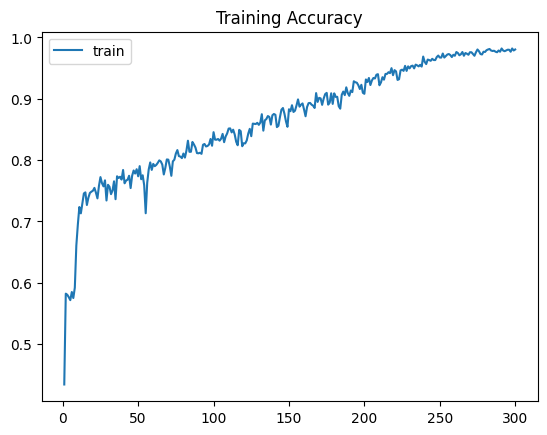

'etc/saved_models/DD/checkpoint_5700'

In [9]:
# 4 columns: train-loss train-accuracy valid-loss valid-accuracy
stats = np.loadtxt(path)

if len(stats.shape) == 1:
    stats = stats[None]

train_loss, valid_loss = stats[:, 0], stats[:, 2]
train_accuracy, valid_accuracy = stats[:, 1], stats[:, 3]

# total epochs
xlimit = np.arange(1, stats.shape[0] + 1)

plt.title('Training Loss')
plt.plot(xlimit, train_loss, label = 'train')
plt.legend()
plt.show()

plt.title('Training Accuracy')
plt.plot(xlimit, train_accuracy, label = 'train')
plt.legend()
plt.show()

if to_device:
    state = flax.jax_utils.unreplicate(state)
    to_device = False

checkpoints.save_checkpoint(ckpt_dir = saved_dir, target = state, overwrite = True, step = epochs * len(train_loader))